# Implementation


### Genetic Algorithm

In [157]:
class genetic_algorithm():#, p_cross=0.5, p_mut=0.5, p_inv=0.5, eps=1e-5):
    import random
    import math
    import numpy as np
    
    def __init__(self, f, low, high, eps=1e-2, eps2=1e-2):
        self.f = f
        self.low = low
        self.high = high
        self.eps = eps
        self.eps2 = eps2
        self.d = self.high - self.low
        k = int(self.d / self.eps + 1)
        gen_len = int(math.log(k, 2)) + 1
        self.k = 2 ** gen_len + 1
        
        self._create_sets()
   

    def _create_sets(self):
        """
        create phenotype, integer represantation of phenotype and genotype
        """
        self.phenotype = np.linspace(self.low, self.high, self.k)
        self.phenotype_int = dict(zip(self.phenotype, range(self.k)))
        
        self.gen_len = int(math.log(self.k, 2)) + 1
        self.genotype = np.array([self._int_to_bin(el) for el in self.phenotype_int.values()])
        
        self.fitness = np.array([self.f(el) for el in self.phenotype])
      
    
    def _int_to_bin(self, int_number):
        """
        return a binary represantation of an integer
        """
        return str(bin(int_number)[2:]).zfill(self.gen_len)
        
    def _bin_to_int(self, bin_number):
        """
        return an integer decimal represantation of binary
        """
        return int(str(bin_number), 2)
   
    def _float_to_int(self, float_number):
        """
        return integer representation of float (index of phenotype)
        """
        return self.phenotype_int[float_number]
    
    def _int_to_float(self, int_number):
        """
        return float of as a phenotype in index
        """
        return self.phenotype[min(int_number,self.k-1)]

    def _float_to_bin(self, float_number):
        """
        return composition of _float_to_int & _int_to_bin
        """
        return self._int_to_bin(self._float_to_int(float_number))
    
    def _bin_to_float(self, bin_number):
        """
        return composition of _bin_to_int & _int_to_float
        """
        return self._int_to_float(self._bin_to_int(bin_number))
   
    def _find_nearest_element(self, element):
        """
        find nearest element in phenotype to the element
        :param: element - float
        return float element
        """
        return self.phenotype[argmax(-abs(self.phenotype - element))]

    def _evaluate_fitness(self):
        """
        evaluate fitness-function of each element from generation
        """
        self.fitness_of_generation = np.array([self.f(el) for el in self.current_generation])

    def selection(self):
        """
        select randomly two elements from elements with fitness-function > mean
        create current_parents as an array of two floats
        """
        self._evaluate_fitness()
        m = self.fitness_of_generation.mean()
        #population = np.extract(self._evaluate_fitness() > m, self.current_generation)
        indices = np.where(self.fitness_of_generation > m)[0]
        random.shuffle(indices)
        self.parents = np.array(self.current_generation)[indices[:2]] 
        if self.print_out:
            print('-> selected parents: ', self.parents)
            print('-> selected parents (int): ', [self.phenotype_int[p] for p in self.parents])

    def crossover(self):
        """
        implement 1-point crossover
        create two childs from two parents
        """
        #n_coord = selected.shape[1]
        #new_element = np.zeros(n_coord)
        #for i in range(n_coord):
        #    new_element[i] = np.random.choice(selected[:,i], p=[self.p_cross, 1 - self.p_cross])
        #    print(selected[:,i])
        parent0_bin = self._float_to_bin(self.parents[0])
        parent1_bin = self._float_to_bin(self.parents[1])
        if self.print_out:
            print('-> selected parents (binary): ', [parent0_bin, parent1_bin])
        point = np.random.randint(self.gen_len) + 1
        if self.print_out:
            print('-> crossover point: ', point)
        self.left_child = parent0_bin[:point] + parent1_bin[point:]
        self.right_child = parent1_bin[:point] + parent0_bin[point:]
        if self.print_out:
            print('-> created childs (binary): ', [self.left_child,
                                               self.right_child])
        self.left_child = self._bin_to_float(self.left_child)
        self.right_child = self._bin_to_float(self.right_child)
        if self.print_out:
            print('-> created childs (int): ', [self.phenotype_int[self.left_child],
                                      self.phenotype_int[self.right_child]])
        
            print('-> created childs: ', [self.left_child, self.right_child])      
        
    def mutation(self, element):
        """
        inverse each bit of element with probability p
        :param: element - float
        return mutated element as float
        """
        if self.print_out:
            print('->          element: ', element)
        element_bin = self._float_to_bin(element)
        if self.print_out:
            print('->          element (binary): ', element_bin)
        mutated_bin = ''.join(list(map(lambda x: str(1 - int(x))
                                       if np.random.choice([0,1], p=[self.p_mut, 1-self.p_mut]) == 0
                                       else x, element_bin)))
        if self.print_out:
            print('->  mutated element (binary): ', mutated_bin)
        mutated = self._bin_to_float(mutated_bin)
        mutated = self._find_nearest_element(mutated)
        if self.print_out:
            print('->  mutated element: ', mutated)
        return mutated
    
    def inversion(self, element):
        """
        swap bits of element with probability p
        :param: element - float
        return inversed element as float
        """
        if self.print_out:
            print('->          element: ', element)
        element_bin = self._float_to_bin(element)
        if self.print_out:
            print('->          element (binary): ', element_bin)
        mutated_bin = ''.join(list(map(lambda i: element_bin[-i]
                                       if np.random.choice([0,1], p=[self.p_inv, 1-self.p_inv]) == 0
                                       else element_bin[i], range(len(element_bin)))))
        if self.print_out:
            print('-> inversed element (binary): ', mutated_bin)
        mutated = self._bin_to_float(mutated_bin)
        mutated = self._find_nearest_element(mutated)
        if self.print_out:
            print('-> inversed element: ', mutated)
    
    def _mean_gen_distance(self):
        d = 0
        n = len(self.current_generation)
        for i in range(n):
            for j in range(i,n):
                   d += np.linalg.norm(self.current_generation[i] - 
                                       self.current_generation[j])
        return d / n

    def _mean_fit_distance(self):
        d = 0
        n = len(self.fitness_of_generation)
        for i in range(n):
            for j in range(i,n):
                   d += np.linalg.norm(self.fitness_of_generation[i] -
                                       self.fitness_of_generation[j])
        return d / n
    
    def _stop_condition(self, n_iter):
        return self._mean_gen_distance() < self.eps or \
               self._mean_fit_distance() < self.eps2 or \
               n_iter >= self.max_iter
    
    def run_algorithm(self, p_cross=0.5, p_mut=0.01,
                            p_inv=0.01, print_out=True, max_iter=10):
        
        self.print_out = print_out
        self.max_iter = max_iter
        self.p_cross = p_cross
        self.p_mut = p_mut
        self.p_inv = p_inv
    
        self.current_generation = self.phenotype
        self._evaluate_fitness()
        self.new_generation = []
        if self.print_out:
            print('-> current generation:', self.current_generation)
        n_iter = 0
        while not self._stop_condition(n_iter):
            for i in range(self.k):
                self.selection()
                self.crossover()
                self.left_child  = self.mutation(self.left_child)
                #self.left_child  = self.inversion(self.left_child)
                #self.right_child = self.mutation(self.right_child)
                #self.right_child = self.inversion(self.right_child)
                self.new_generation.append(self.left_child)
                #self.new_generation.append(self.right_child)
            self.current_generation = self.new_generation
            self._evaluate_fitness()
            if self.print_out:
                print('-> new generation:', list(set(self.current_generation)))#list(set(self.current_generation)))
                print('-> fitness-function values:', list(set(self.fitness_of_generation)))
            n_iter += 1
                
        return self.current_generation[self.fitness_of_generation.argmax()], self.fitness_of_generation.max()

In [158]:
f = lambda x: 2 * x - x**3 + (1 + x)**.5  + 10
low = 0
high = 8
GA = genetic_algorithm(f, low, high, eps=0.5)
x0, f0 = GA.run_algorithm(print_out=False)
print('x0 = ', x0)
print('f0 = ', f0)

x0 =  1.0
f0 =  12.4142135624


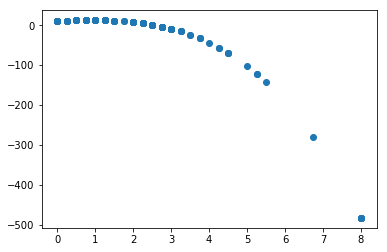

In [159]:
plt.scatter(GA.current_generation, GA.fitness_of_generation)
plt.show()